# Download dataset from kaggle
Install kaggle

In [26]:
!pip3 install -q kaggle

^C


Mount the **gdrive**

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
models_drive_folder = './models'

Colab requires the file to be placed in /.kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Take ownership of the kaggle.json file

Download the dataset

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

100%|██████████████████████████████████████| 1.03G/1.03G [01:53<00:00, 12.2MB/s]
100%|██████████████████████████████████████| 1.03G/1.03G [01:53<00:00, 9.68MB/s]


In [ ]:
import zipfile

FILENAME = "./asl-alphabet.zip"
with zipfile.ZipFile(FILENAME, "r") as f:
    f.extractall('.')

In [ ]:
!ls asl_alphabet_train/asl_alphabet_train/

A/  C/  del/  F/  H/  J/  L/  N/        O/  Q/  S/      T/  V/  X/  Z/
B/  D/  E/    G/  I/  K/  M/  nothing/  P/  R/  space/  U/  W/  Y/


# Prep Pytorch

### Install

In [ ]:
!pip install -q validators matplotlib
!pip install -q torch-summary
!pip install -q torchmetrics

In [1]:
from __future__ import division, print_function

import time
import warnings
from pathlib import Path
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, transforms

warnings.filterwarnings('ignore')
%matplotlib inline

plt.ion()   # interactive mode

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Cuda is available: {torch.cuda.is_available()}')
print(f'Using {device} for inference')

Cuda is available: True
Using cuda for inference


### Dataloaders

In [2]:
import os

import torch
from matplotlib import pyplot as plt

TRAIN_DATA_PATH = "./asl_alphabet_train/asl_alphabet_train"
batch_size = 64

# The transformer is used here to reshape images to 224x224 and convert to tensor
simple_transformer = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

data_dir = os.path.join(str(TRAIN_DATA_PATH))

# ImageFolder is a generic data set where the images are arranged in sub-folders corresponding to classes
dataset = datasets.ImageFolder(data_dir, simple_transformer)
generator = torch.Generator().manual_seed(42)

train_set, val_set, test_set = torch.utils.data.random_split(
    dataset, [0.8, 0.1, 0.1], generator
)
image_datasets = {"train": train_set, "val": val_set, "test": test_set}

dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}

# Combines a dataset and a sampler, and provides an iterable over the given dataset.
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4
    )
    for x in image_datasets
}

class_names = dataset.classes
print(f"Dataset sizes: {dataset_sizes}")
print(f"Classes: {class_names}")

Dataset sizes: {'train': 69600, 'val': 8700, 'test': 8700}
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [3]:
import matplotlib.pyplot as plt


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Models

### Load resneXt model

In [11]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# Set model name here for rest of the code
version = "adam"
model_name = f"resnext_{version}"

model.eval().to(device)

model_ft =  torch.nn.Linear(model.fc.in_features, len(class_names), bias=True).to(device)

model.fc = model_ft
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

finetuneable_layers = [model.layer4]


Using cache found in /home/benjamin/.cache/torch/hub/pytorch_vision_v0.10.0


23039325


Using cache found in /home/benjamin/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


### Load Mobilenet Model

In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

# Set model name here for rest of the code
model_name = "mobilenet_v1"

model.eval().to(device)

model_ft =  torch.nn.Linear(model.classifier[1].in_features, len(class_names), bias=True).to(device)

model.classifier[1] = model_ft

# print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)
finetuneable_layers = [model.features[17], model.features[18]]

Using cache found in /home/benjamin/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/benjamin/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


2261021


# Transfer Learning

In [ ]:
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

### Training method

In [12]:
def save_checkpoint(epoch, model, optimizer, scheduler, filename):
    checkpoint = {
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(model, optimizer, scheduler, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    previous_epoch_num = checkpoint["epoch"]
    return model, optimizer, scheduler, previous_epoch_num

In [6]:
def train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    save_dir=".",
    num_epochs=25,
    previous_epochs=0,
):
    since = time.time()

    best_model_params_path = os.path.join(save_dir, "best_model_params.pt")
    history_path = os.path.join(save_dir, "model_history.pt")

    # Create save directory if it doesn't exist
    if save_dir != ".":
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    best_acc = 0.0
    history = {
        "loss": [],
        "accuracy": [],
        "val_loss": [],
        "val_accuracy": [],
        "lr": [],
        "batch_size": batch_size,
    }
    for epoch in range(num_epochs):
        epoch_num = previous_epochs + epoch + 1
        print(f"Epoch {epoch_num}/{previous_epochs + num_epochs}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
                print(f"Learning rate: {scheduler.get_lr()}")
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "val":
                history["val_loss"].append(epoch_loss)
                history["val_accuracy"].append(epoch_acc.item())
            elif phase == "train":
                history["loss"].append(epoch_loss)
                history["accuracy"].append(epoch_acc.item())
                history["lr"].append(scheduler.get_lr())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                print(
                    f"Found new best accuracy! Saving best model to {best_model_params_path}..."
                )
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        # Save checkpoint and history after each epoch
        save_checkpoint(
            epoch_num,
            model,
            optimizer,
            scheduler,
            os.path.join(save_dir, f"epoch_{epoch_num}_checkpoint.pt"),
        )
        torch.save(history, history_path)

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best accuracy: {best_acc}")

    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model, history

In [13]:
def get_last_model_params(model_name, model, optimizer, scheduler):
    # Find model param files
    try:
        model_dir_path = os.path.join(model_name)
        dir_paths = os.listdir(model_dir_path)
        model_params = [
            f
            for f in dir_paths
            if f.startswith("epoch") and f.endswith("_checkpoint.pt")
        ]

        if len(model_params) == 0:
            raise Exception()

        model_params.sort()

        # Load history
        history_path = os.path.join(model_dir_path, "model_history.pt")
        history = torch.load(history_path)

        # Print accuracy for each model param file
        epochs_dicts = [
            {"epoch": epoch + 1, **{key: history[key][epoch] for key in history}}
            for epoch in range(len(history["accuracy"]))
        ]

        print("Old epochs:")
        print("-" * 10)
        print()
        for epoch_dict in epochs_dicts:
            # Print "print" statements from train_model function
            print(f"Epoch {epoch_dict['epoch']}/{len(epochs_dicts)}")
            print("-" * 10)

            print(
                f"train Loss: {epoch_dict['loss']:.4f} Acc: {epoch_dict['accuracy']:.4f}"
            )
            print(
                f"val Loss: {epoch_dict['val_loss']:.4f} Acc: {epoch_dict['val_accuracy']:.4f}"
            )
            print()

        # Load model params from last model param file

        latest_model_params_path = os.path.join(model_dir_path, model_params[-1])

        model, optimizer, scheduler, previous_epoch_num = load_checkpoint(
            model,
            optimizer,
            scheduler,
            latest_model_params_path,
        )

        print("Model loaded: ", os.path.join(model_dir_path, model_params[-1]))
        print("Continue training ...")
        print()

        return model, optimizer, scheduler, previous_epoch_num
    except:
        print("No model checkpoints found" + "\n")
        return model, optimizer, scheduler, 0

### Training

In [14]:
continue_train = True
previous_epochs = 0

# Params for the model
for param in model.parameters():
    param.requires_grad = False

# model.fc.requires_grad = True
for param in model_ft.parameters():
    param.requires_grad = True

## Set training mode
model.train()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_ft.parameters(), lr=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if continue_train:
    model, optimizer, scheduler, previous_epochs = get_last_model_params(
        model_name, model, optimizer, scheduler
    )

trained_model, history_tl = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
    previous_epochs=previous_epochs,
    save_dir=model_name,
)

No model checkpoints found

Epoch 1/25
----------
Learning rate: [0.0001]
train Loss: 2.0032 Acc: 0.6680
val Loss: 1.1901 Acc: 0.8363
Found new best accuracy! Saving best model to resnext_adam/best_model_params.pt...

Epoch 2/25
----------
Learning rate: [0.0001]
train Loss: 0.9621 Acc: 0.8520
val Loss: 0.7412 Acc: 0.8777
Found new best accuracy! Saving best model to resnext_adam/best_model_params.pt...

Epoch 3/25
----------
Learning rate: [0.0001]
train Loss: 0.6639 Acc: 0.8867
val Loss: 0.5546 Acc: 0.8999
Found new best accuracy! Saving best model to resnext_adam/best_model_params.pt...

Epoch 4/25
----------
Learning rate: [0.0001]
train Loss: 0.5200 Acc: 0.9028
val Loss: 0.4477 Acc: 0.9159
Found new best accuracy! Saving best model to resnext_adam/best_model_params.pt...

Epoch 5/25
----------
Learning rate: [0.0001]
train Loss: 0.4329 Acc: 0.9151
val Loss: 0.3870 Acc: 0.9202
Found new best accuracy! Saving best model to resnext_adam/best_model_params.pt...

Epoch 6/25
----------


In [ ]:
model.eval()
print(inputs.shape)
output = model(inputs.to(device))
print(output.shape)
probabilities = torch.nn.functional.softmax(output, dim=1)
# print(probabilities)


top5_prob, top5_catid = torch.topk(probabilities, 1)
out = torchvision.utils.make_grid(inputs)

class_names_out = [class_names[x] for x in top5_catid]

imshow(out, title=class_names_out)

for i in range(top5_prob.size(0)):
    print(class_names[top5_catid[i]], top5_prob[i].item())



NameError: name 'inputs' is not defined

# Model results

Bemi <3

Model results parameters to see effects of fine tuning etc.

### Get predictions

In [9]:
model_name = "mobilenet_v1_finetune"
model_path = f'{model_name}/best_model_params.pt'
result = model.load_state_dict(torch.load(model_path))
print(result)

<All keys matched successfully>


In [5]:
def get_predictions(model, modelPath):
  '''
  Get predictions from the model. Returns three lists of the true classes, predicted classes, and probability of true class
  '''
  # Load model from path
  model.load_state_dict(torch.load(modelPath))
  # Model predictions
  y_predictions = []
  # Model prediction of the true class
  y_true_prob = []
  # Model all class probabilities
  y_probs = []
  # True class label
  y_true = []
  for inputs, classes in dataloaders['test']:
    # Add class to true array
    true_classes = classes.numpy()
    y_true.extend(true_classes)

    # Predict with model
    output = model(inputs.to(device))

    # Output probabilities
    probabilities = torch.nn.functional.softmax(output, dim=1)
    _, top1_catid = torch.topk(probabilities, 1)
    _probs = probabilities.detach().cpu().numpy()
    _y_true_prob = [p[c] for p, c in zip(_probs, true_classes)]
    y_probs.extend(_probs.tolist())

    # Add top_1 to prediction array
    y_predictions.extend([i[0] for i in top1_catid.detach().cpu().numpy()])
    y_true_prob.extend(_y_true_prob)

  return y_true, y_predictions, y_true_prob, y_probs


In [10]:
y_true, y_predictions, y_true_prob, y_probs = get_predictions(model, model_path)

print(y_true[:5], y_predictions[:5], y_true_prob[:5], y_probs[:5])

OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 3.81 GiB total capacity; 3.04 GiB already allocated; 37.06 MiB free; 3.08 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Calculate results

In [23]:
from torch import tensor
from torchmetrics import PrecisionRecallCurve
from torchmetrics.classification import (
    MulticlassAUROC,
    MulticlassAveragePrecision,
    Recall,
)


def precision_and_recall(y_true, y_probs):
  pr_curve = PrecisionRecallCurve(task="multiclass", num_classes=len(class_names))
  precision, recall, thresholds = pr_curve(tensor(y_probs), tensor(y_true))

  return precision, recall, thresholds, pr_curve

def average_precision_and_recall(y_true, y_probs, average):
  average_precision_class = MulticlassAveragePrecision(num_classes=len(class_names), average=average, thresholds=None)
  ave_prec = average_precision_class(tensor(y_probs), tensor(y_true))

  average_recall_class = Recall(task="multiclass", num_classes=len(class_names), average=average)
  ave_rec = average_recall_class(tensor(y_probs), tensor(y_true))

  return (ave_prec, ave_rec), (average_precision_class, average_recall_class)

def auc_roc(y_true, y_probs, average=None):
  auc = MulticlassAUROC(num_classes=len(class_names), average=average)(tensor(y_probs), tensor(y_true))
  return auc


In [24]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
)


def format_values(values, decimals=3):
    print(values[:5])
    moderator = 10**decimals
    return [int(v * moderator) / moderator for v in values]


def gen_confusion_matrix(y_true, y_predictions):
    cm = confusion_matrix(y_true, y_predictions, normalize="true")
    confusion_matrix_plot = ConfusionMatrixDisplay(cm, display_labels=class_names)
    return confusion_matrix_plot


def get_results(y_true, y_predictions, y_probs, average):
    """
    NOTE: Function is work in progress, not tested yet!

    Output results:
      Accuracy
      Confusion Matrix (not a metric but fundamental to others)
      Precision and Recall
      F1-score
      AU-ROC
    """

    # Accuracy
    acc = accuracy_score(y_true, y_predictions)
    print(f"Accuracy: {acc}")

    # Confusion matrix
    cfm = gen_confusion_matrix(y_true, y_predictions)

    # Precision and Recall
    precision, recall, _, pr_curve = precision_and_recall(y_true, y_probs)
    (ave_precision, ave_recall), _ = average_precision_and_recall(
        y_true, y_probs, average="macro"
    )
    print(f"Average precision and recall: {ave_precision}, {ave_recall}")

    # F1-score
    f1_scores = f1_score(y_true, y_predictions, average=average)
    print(f"F1 score ({average}): {f1_scores}")

    # AU-ROC score
    auc = auc_roc(y_true, y_probs, average=average)
    print(f"AUC: {auc}")

    return (
        (y_true, y_predictions),
        acc,
        cfm,
        (precision, recall, pr_curve),
        (ave_precision, ave_recall),
        f1_scores,
        auc,
        average,
    )

### Save model to *JSON*

In [26]:
import json


result_json_path = "./results.json"

def clear_model_results(model_name):
    try:
        f = open(result_json_path, "r")
        results_json = json.load(f)
        f.close()

        def filt(res, modelname):
            return res["Model"] != modelname

        results_json = list(filter(lambda res: filt(res, model_name), results_json))

        f = open(result_json_path, "w")
        f.write(json.dumps(results_json))
        f.close()
    except Exception as e:
        print(e)
        pass


def save_model_results(model_name, results):
    (
        (y_true, y_predictions),
        acc,
        cfm,
        (precision, recall, pr_curve),
        (ave_precision, ave_recall),
        f1_scores,
        auc,
        average_method,
    ) = results

    clear_model_results(model_name)

    resultdict = {
        "Model": model_name,
        "Accuracy": acc.astype(float),
        "Average precision": ave_precision.numpy().item(),
        "Average recall": ave_recall.numpy().item(),
        "F1 scores": f1_scores.astype(float),
        "AUC": auc.numpy().item(),
        "Averaging method": average_method,
    }

    # Append results
    try:
        f = open(result_json_path, "r")
        results_json = json.load(f)
        results_json.append(resultdict)
        f.close()
    except Exception as e:
        print(e)
        results_json = [resultdict]

    f = open(result_json_path, "w+")
    f.write(json.dumps(results_json))
    f.close()

In [4]:
results = get_results(y_true, y_predictions, y_probs, "macro")
save_model_results(model_name, results)

NameError: name 'get_results' is not defined

In [29]:
!pip install -q py-markdown-table

In [35]:
from py_markdown_table.markdown_table import markdown_table


def plot_table_results():
  """
  Plot a table of the results in the "results.json"
  """

  f = open(result_json_path, "r")
  data = json.load(f)

  # decimals
  for row in data:
    for key in row:
      if (type(row[key]) == float):
        row[key] = float("{:.4f}".format(row[key]))

  markdown = markdown_table(data).get_markdown()
  print(markdown)

In [52]:
plot_table_results()

```
+----------------------------------------------------------------------------------------+
|    Model   |Accuracy|Average precision|Average recall|F1 scores|  AUC |Averaging method|
+------------+--------+-----------------+--------------+---------+------+----------------+
|resnext_adam| 0.9364 |      0.9792     |    0.9374    |  0.9369 |0.9988|      macro     |
+------------+--------+-----------------+--------------+---------+------+----------------+
| resnext_v1 | 0.9032 |      0.9545     |    0.9048    |  0.9035 |0.9969|      macro     |
+------------+--------+-----------------+--------------+---------+------+----------------+
| resnext_v2 | 0.9064 |      0.9582     |    0.9077    |  0.9069 |0.9972|      macro     |
+----------------------------------------------------------------------------------------+```


### Save Confusion matrix and Precision-recall curve

In [39]:
from matplotlib import pyplot as plt


# Plots
def save_cfm_plot(modelname, results):
  confusion_matrix_plot = results[2]
  confusion_matrix_plot.plot()
  confusion_matrix_plot.figure_.set_size_inches((25, 25))
  if not os.path.exists(f"{modelname}/results"):
    os.makedirs(f"{modelname}/results")
  confusion_matrix_plot.figure_.savefig(f"{modelname}/results/cfm.png", dpi=300, bbox_inches='tight')

# Plots
def save_pr_curve_plot(modelname, results):
  pr_curve_plot = results[3][2]
  fig, ax = pr_curve_plot.plot()
  ax.legend(labels=class_names)
  fig.set_size_inches((14, 14))
  ax.set_title("Precision/Recall curve")
  ax.set_xlabel("Recall")
  ax.set_ylabel("Precision")
  if not os.path.exists(f"{modelname}/results"):
    os.makedirs(f"{modelname}/results")
  fig.savefig(f"{modelname}/results/pr.png", dpi=300, bbox_inches='tight')

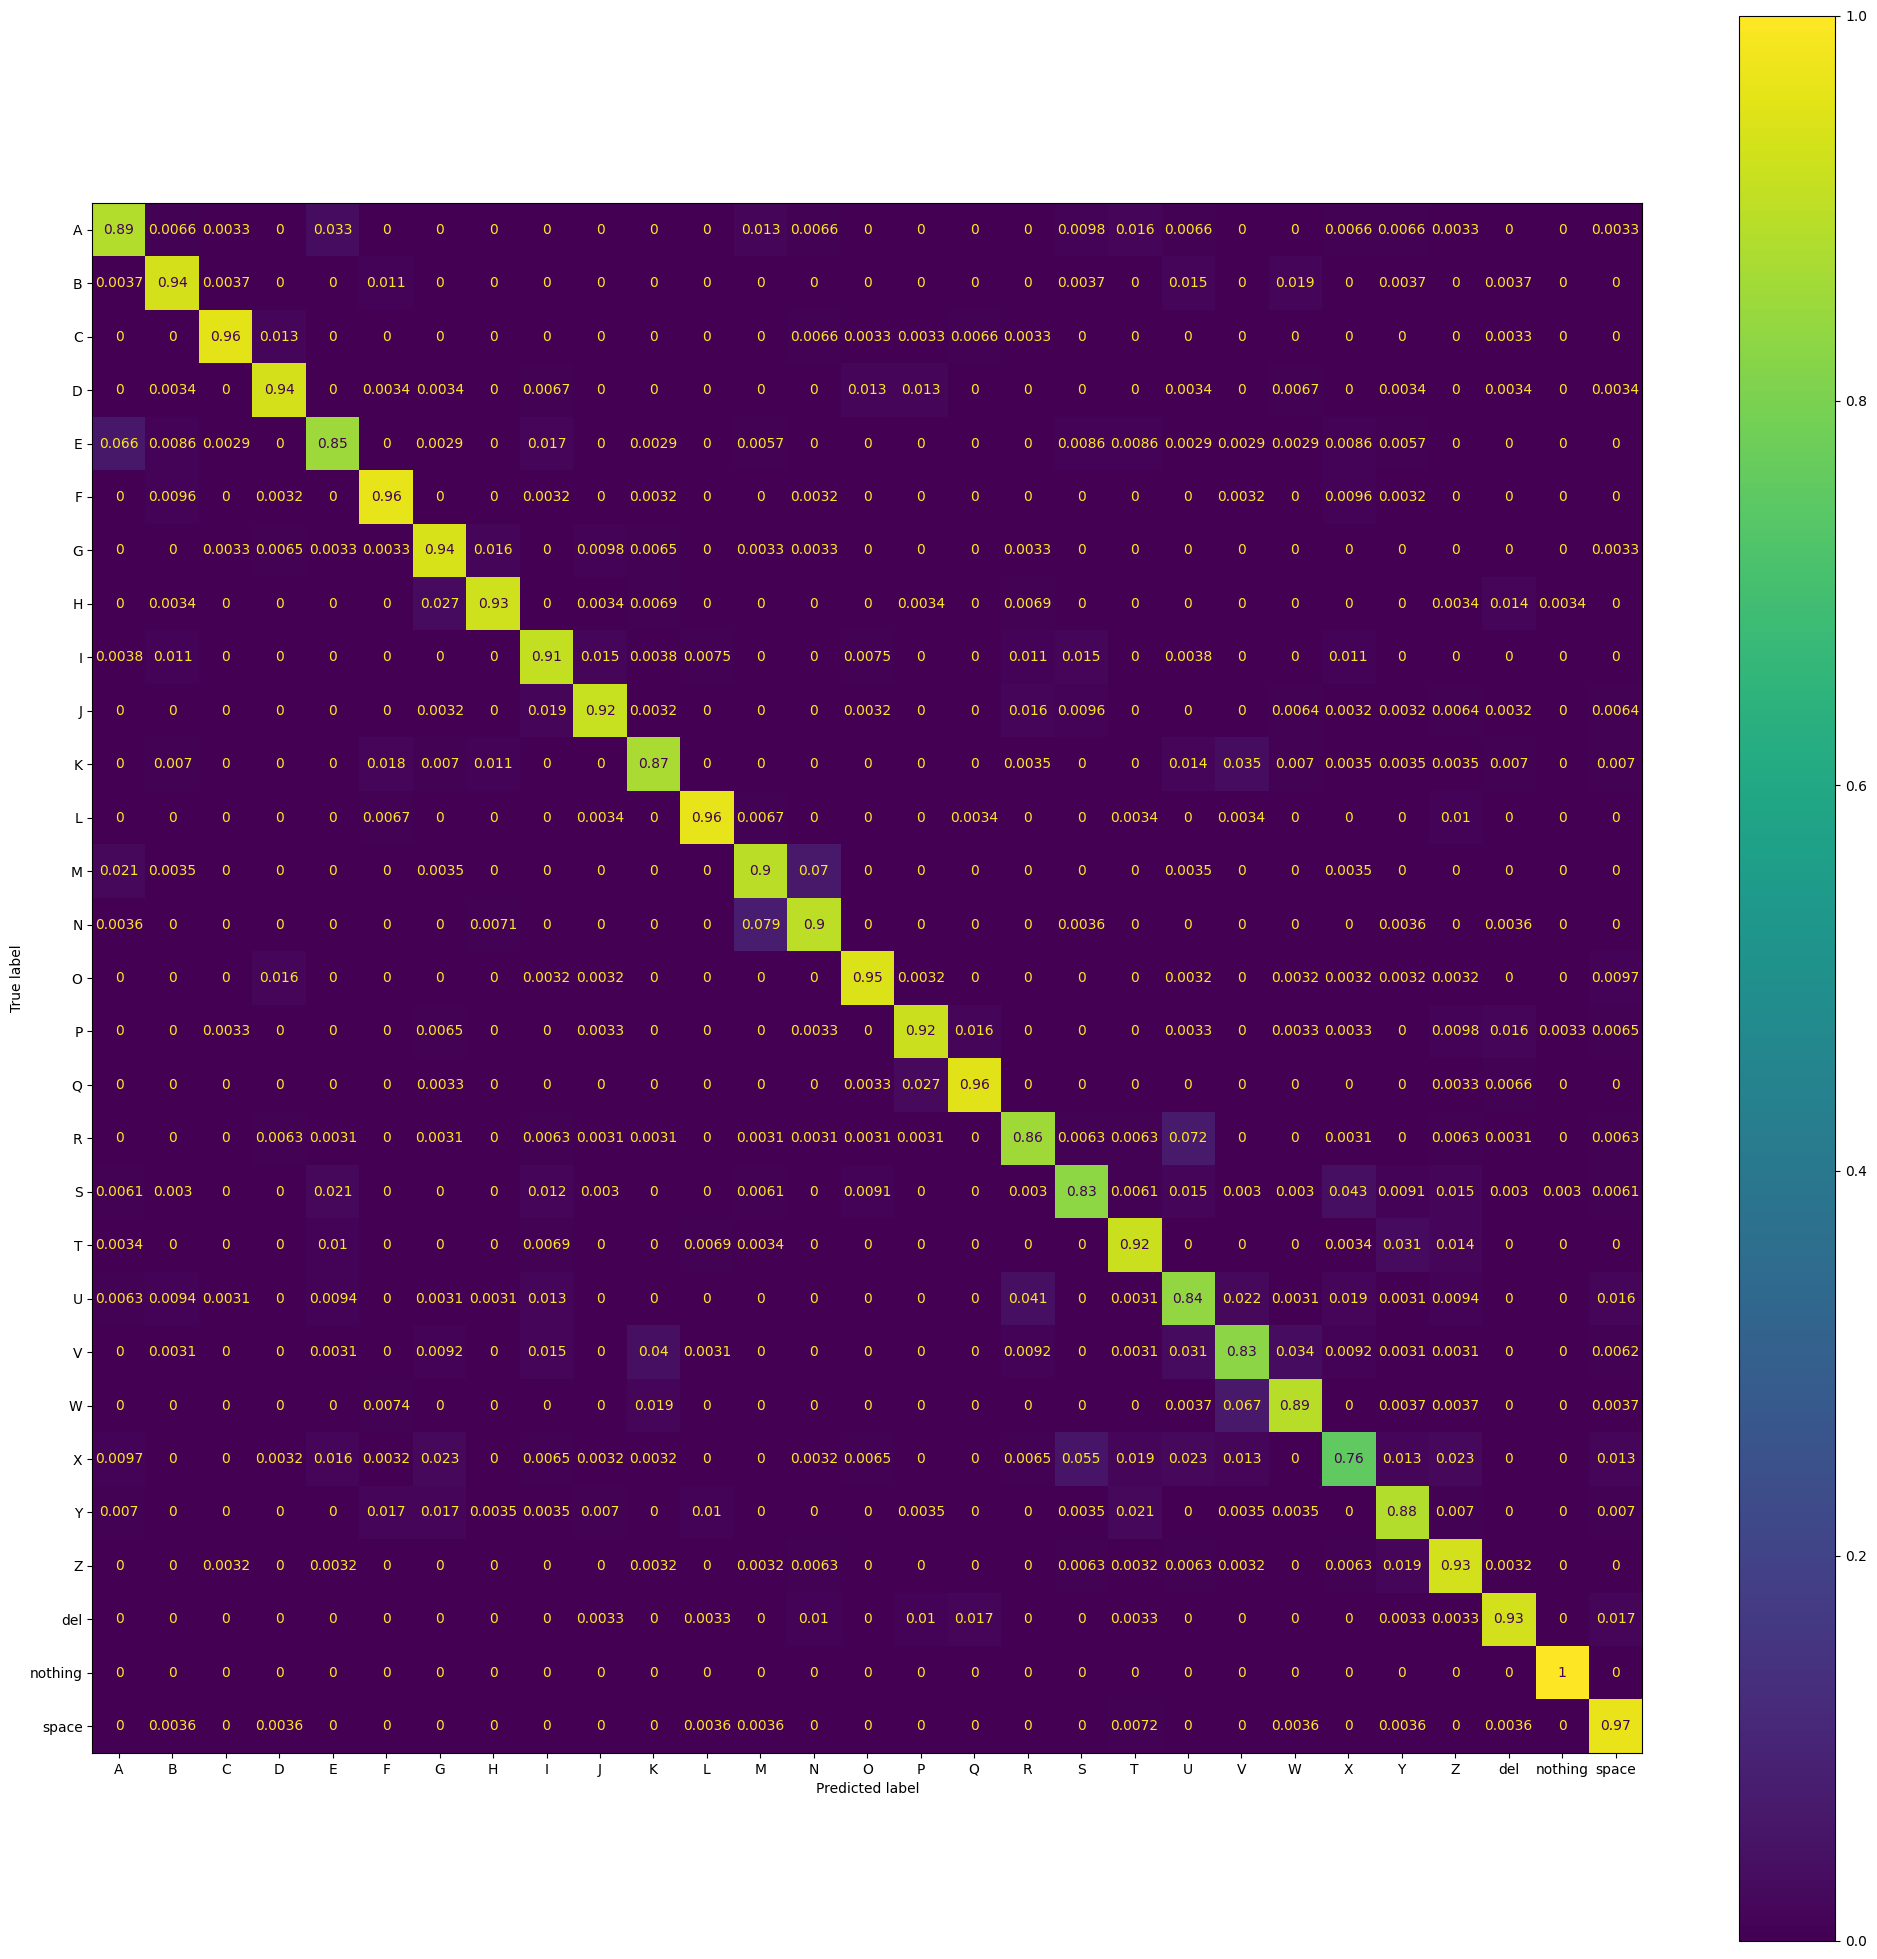

In [53]:
save_cfm_plot(model_name, results)

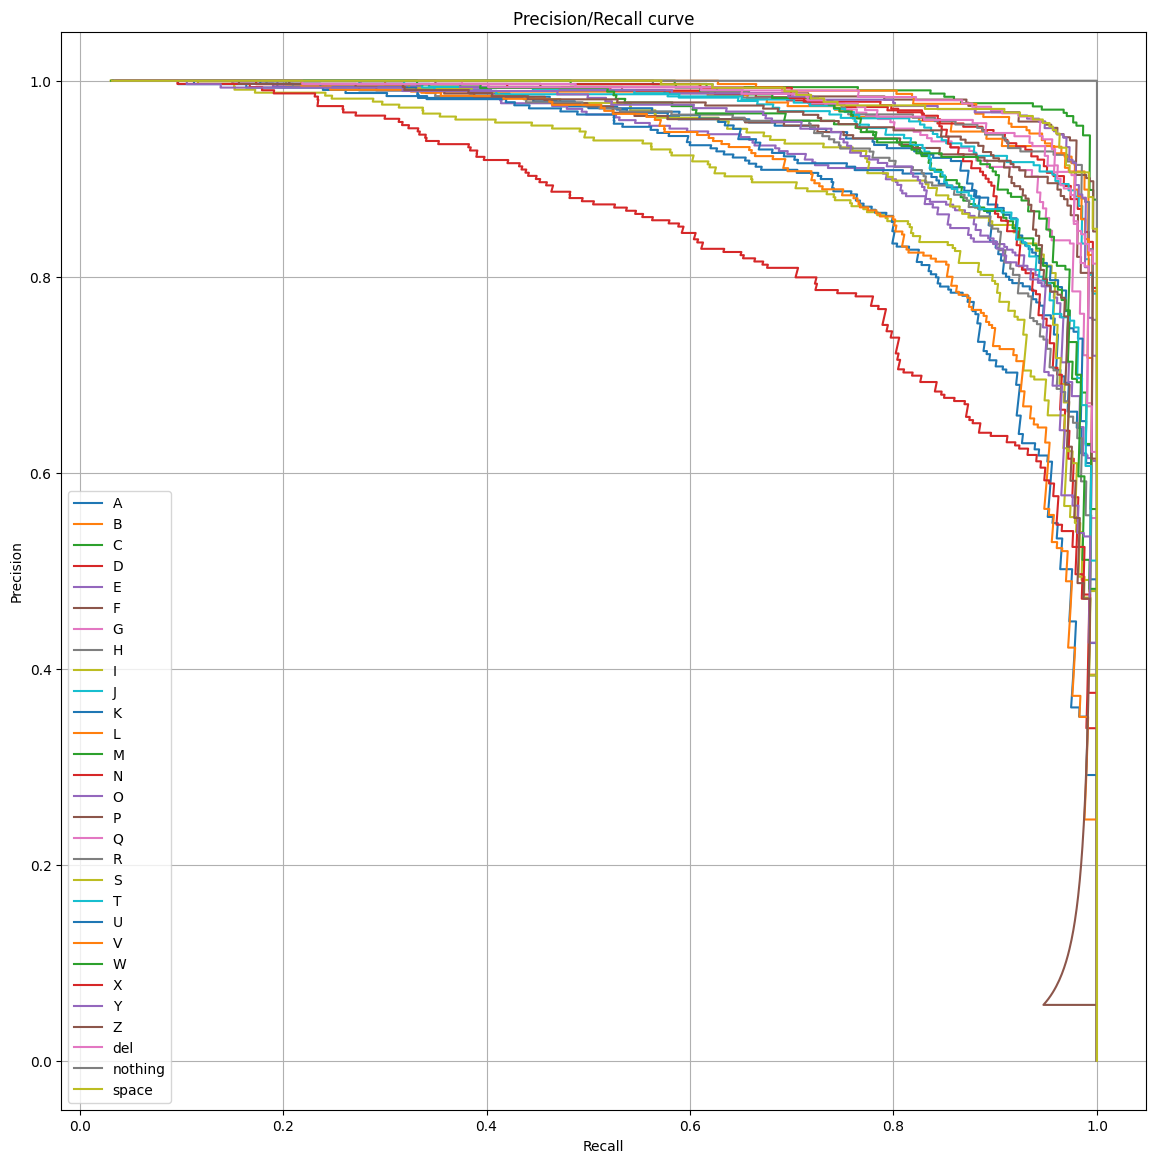

In [54]:
save_pr_curve_plot(model_name, results)

# Fine Tuning

In [ ]:
result = model.load_state_dict(torch.load(model_path))

In [ ]:
## Training

for param in model.parameters():
    param.requires_grad = False

model_ft.requires_grad = True
for layer in finetuneable_layers:

  for param in layer.parameters():
    param.requires_grad = True

## Set training mode
model.train()


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.01)
fiunetuned_model, history_ft = train_model(model, dataloaders, criterion, optimizer, scheduler,
                       num_epochs=5, save_dir='mobilenet_v1_finetune')



Epoch 1/5
----------
train Loss: 0.3262 Acc: 0.9356
val Loss: 0.2690 Acc: 0.9599
Found new best accuracy! Saving best model to mobilenet_v1_finetune/best_model_params.pt...

Epoch 2/5
----------
train Loss: 0.3285 Acc: 0.9343
val Loss: 0.2688 Acc: 0.9600
Found new best accuracy! Saving best model to mobilenet_v1_finetune/best_model_params.pt...

Epoch 3/5
----------
train Loss: 0.3274 Acc: 0.9356
val Loss: 0.2665 Acc: 0.9597

Epoch 4/5
----------
train Loss: 0.3276 Acc: 0.9353
val Loss: 0.2664 Acc: 0.9613
Found new best accuracy! Saving best model to mobilenet_v1_finetune/best_model_params.pt...

Epoch 5/5
----------
train Loss: 0.3262 Acc: 0.9365
val Loss: 0.2697 Acc: 0.9593

Training complete in 27m 14s
Best accuracy: 0.9612643678160919


# Receptive field analysis

Rasmus <3

Check whether neurons are blank to argue whether or not ResNeXt is too overkill. Can argue for modifying ResNeXt or choosing a more light weight model.

# Plot loss over epochs

Mamus <3

Gather information for learning rate in fine tuning.
See Howard

In [17]:

def show_history(history):
  plt.figure(figsize=(20,6))

  # # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

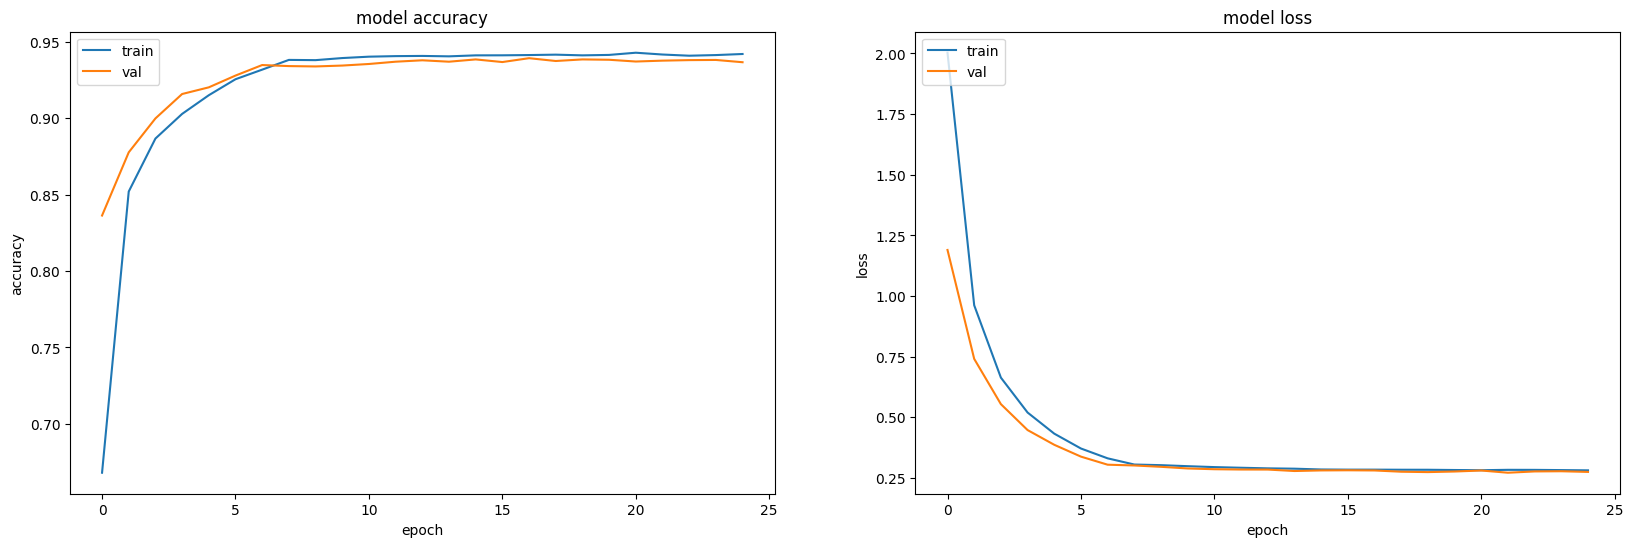

In [18]:
# Load history file
history = torch.load(f"{model_name}/model_history.pt")
show_history(history)

# Class Activation Maps

In [ ]:
!pip install -q torchcam

torch.Size([100, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


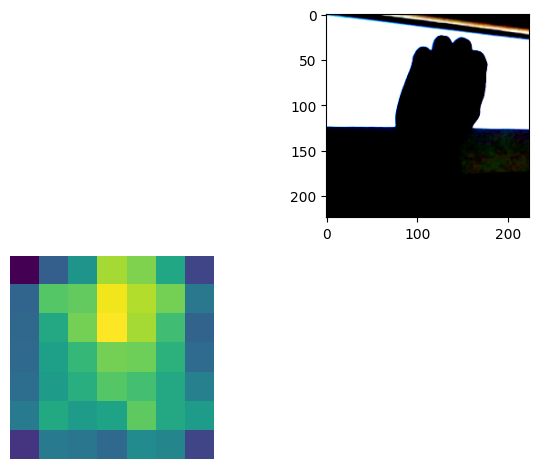

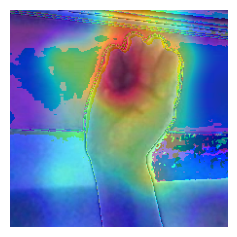

In [32]:

from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image

cam_extractor = SmoothGradCAMpp(model, model.features[18])
images, labels = next(iter(dataloaders['val']))

for param in model.parameters():
    param.requires_grad = True

model.eval()
model_path = f'{model_name}/best_model_params.pt'

result = model.load_state_dict(torch.load(model_path))


  # Preprocess your data and feed it to the model
print(images.shape)
print(images[:1].shape)
print(images[0].shape)
out = model(images[:1].to(device))
  # Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

result = overlay_mask(to_pil_image(images[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
plt.subplot(222)
imshow(images[0])
plt.subplot(223)
plt.imshow(activation_map[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()
plt.subplot(224)
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()